In [33]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler

In [41]:
def open_root_files(file_names,tree):
    file = uproot.open(file_names)
    tree_name = file[tree]
    return tree_name

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]

    for var in train_variables:
        if(var == "classification"):
            continue
        else:
            varDf = dict[key][var].array(library = 'pd')
            if(varDf.index.nlevels == 2):
                df[var] = varDf.reset_index(level=1, drop=True)
            else:
                df[var] = varDf

    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, bias, train_tensor):
    model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(train_tensor.shape[1],), bias_initializer=keras.initializers.Constant(bias)),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model


In [35]:
#open the files
signal_file_e = open_root_files("mc16e_signal.root","nominal")
#signal_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_signal.root","nominal")
#signal_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_signal.root","nominal")
ttbar_file_e = open_root_files("mc16e_ttbar.root","nominal")
#ttbar_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_ttbar.root","nominal")
#ttbar_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_ttbar.root","nominal")
#wjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_wjets.root","nominal")
#wjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_wjets.root","nominal")
#wjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_wjets.root","nominal")
#diboson_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_diboson.root","nominal")
#diboson_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_diboson.root","nominal")
#diboson_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_diboson.root","nominal")
#zjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_zjets.root","nominal")
#zjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_zjets.root","nominal")
#zjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_zjets.root","nominal")
#singletop_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_singletop.root","nominal")
#singletop_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_singletop.root","nominal")
#singletop_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_singletop.root","nominal")

SIGNAL CLASSIFICATION SET TO 1 signal_e


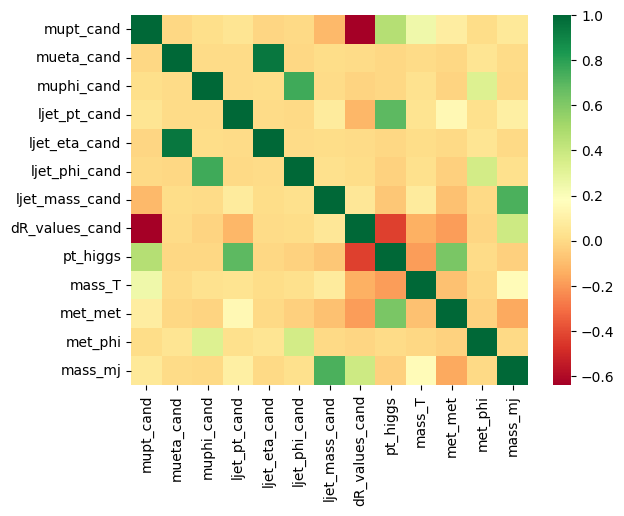

BACKGROUND CLASSIFICATION SET TO 0 ttbar_e


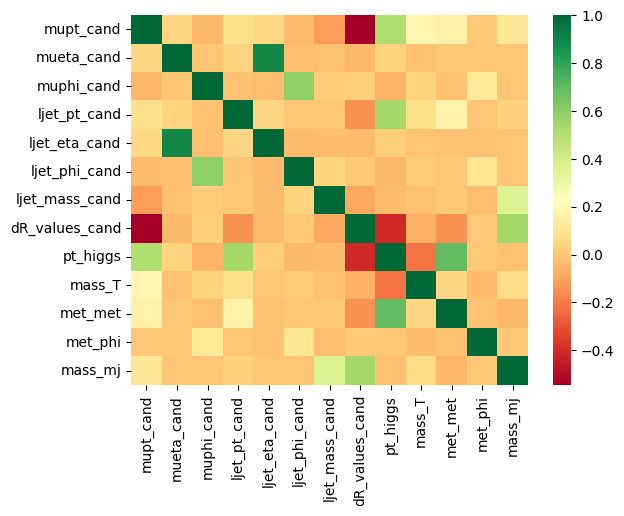

entry
1117    0.012345
2963    0.005907
658     0.010077
784     0.006761
3228    0.006675
          ...   
1379    0.008428
2725    0.013664
282     0.004281
2505    0.005418
2600    0.004073
Name: weight, Length: 2124, dtype: float64
entry
2005    0.056826
545     0.084136
291     0.117633
2487    0.089684
1054    0.070758
          ...   
1858    0.140954
2913    0.147718
611     0.138199
2645    0.090284
975     0.098923
Name: weight, Length: 2259, dtype: float64
Examples:  Total: 4383  Positive: 2124  Negative: 2259  Ratio: 0.48459958932238195
[1 1 1 ... 0 0 0]
[0.01234549 0.00590746 0.0100772  ... 0.13819895 0.09028398 0.0989232 ]
[242.67623233  14.13514567]
Weighted Training Events:  Total: 256.8113780068087  Positive: 14.135145671911514  Negative: 242.67623233489718  Ratio: 0.05504096345581993
Weighted Test Events:  Total: 79.26696450713885  Positive: 4.569461142339115  Negative: 74.69750336479974  Ratio: 0.05764647568821164
Weighted Validation Events:  Total: 63.85583121102692

In [36]:
# variables = ['classification','mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                    'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                    'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']
# variables = ['classification','mupt_cand','ljet_pt_cand','ljet_mass_cand','dR_values_cand','pt_higgs','mass_T', 'met_met', 'mass_mj', 'weight']
variables = ['classification', 'mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(variables, {"signal_e" : signal_file_e})
ttbar_train_e, ttbar_train_class_e, ttbar_train_weights_e, ttbar_test_e, ttbar_test_class_e, ttbar_test_weights_e, ttbar_val_e, ttbar_val_class_e, ttbar_val_weights_e  = create_tensor_object(variables, {"ttbar_e" : ttbar_file_e})

train_df = pd.concat([signal_train_e, ttbar_train_e])
train_class = np.concatenate([signal_train_class_e, ttbar_train_class_e])
train_weight = np.concatenate([signal_train_weights_e, ttbar_train_weights_e])
print(signal_train_weights_e)
print(ttbar_train_weights_e)

test_df = pd.concat([signal_test_e, ttbar_test_e])
test_class = np.concatenate([signal_test_class_e, ttbar_test_class_e])
test_weight = np.concatenate([signal_test_weights_e, ttbar_test_weights_e])

val_df = pd.concat([signal_val_e, ttbar_val_e])
val_class = np.concatenate([signal_val_class_e, ttbar_val_class_e])
val_weight = np.concatenate([signal_val_weights_e, ttbar_val_weights_e])

scaled_train_df = StandardScaler().fit_transform(train_df)
scaled_test_df = StandardScaler().fit_transform(test_df)
scaled_val_df = StandardScaler().fit_transform(val_df)

#print total number of events in each sample
neg, pos = np.bincount(train_class)
total = neg + pos
print('Examples:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total, pos, neg, pos / total))
class_weight = {0: total/(2*neg), 1: total/(2*pos)}

#print weighted number of Total, Positive, Negative, and Ratio
neg_weighted, pos_weighted = np.bincount(train_class, weights=train_weight)
print(train_class)
print(train_weight)
print(np.bincount(train_class, weights=train_weight))
total_weighted = neg_weighted + pos_weighted
print('Weighted Training Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted, pos_weighted, neg_weighted, pos_weighted / total_weighted))

#print weighted number of total, positive, negative, and ratio for test set 
neg_weighted_test, pos_weighted_test = np.bincount(test_class, weights=test_weight)
total_weighted_test = neg_weighted_test + pos_weighted_test
print('Weighted Test Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_test, pos_weighted_test, neg_weighted_test, pos_weighted_test / total_weighted_test))

#print weighted number of total, positive, negative, and ratio for validation set
neg_weighted_val, pos_weighted_val = np.bincount(val_class, weights=val_weight)
total_weighted_val = neg_weighted_val + pos_weighted_val
print('Weighted Validation Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_val, pos_weighted_val, neg_weighted_val, pos_weighted_val / total_weighted_val))

#print total numbers
print('Total Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted + total_weighted_val + total_weighted_test,\
       pos_weighted + pos_weighted_val + pos_weighted_test, neg_weighted + neg_weighted_val + neg_weighted_test, \
       (pos_weighted + pos_weighted_val + pos_weighted_test) / (total_weighted + total_weighted_val + total_weighted_test)))

In [37]:
#Make plots for all of the input training variables
# for i in range(len(train_df.columns)):
#     plt.hist(train_df[train_df.columns[i]][train_class == 0], bins=50, histtype='step', label='Background', color='blue', weights=train_weight[train_class == 0])
#     plt.hist(train_df[train_df.columns[i]][train_class == 1], bins=50, histtype='step', label='Signal', color='red', weights=train_weight[train_class == 1])
#     plt.xlabel(train_df.columns[i])
#     plt.legend()
#     plt.show()
#     # plt.savefig('plots/{}_train.png'.format(train_df.columns[i]))
#     # plt.clf()

#set new weight using class weight
train_weight = train_weight * [class_weight[i] for i in train_class]
bias = pos / total

In [38]:
#set new weight using class weight
# train_weight = train_weight * [class_weight[i] for i in train_class]
# bias = pos / total

In [42]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)
nn_model = get_model(METRICS, bias, scaled_train_df)
nn_fit = nn_model.fit(scaled_train_df, train_class, batch_size=256, epochs=400, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])
# validation_data=(scaled_val_df, val_class),
y_scores = nn_model.predict(scaled_test_df)
nn_model.save('nn_model_4_hidden_256_128_64_32_16_8_input.h5')

Epoch 1/400
14/18 [======================>.......] - ETA: 0s - loss: 0.0442 - tp: 888.0000 - fp: 866.0000 - tn: 965.0000 - fn: 865.0000 - accuracy: 0.5170 - precision: 0.5063 - recall: 0.5066 - auc: 0.5148 - prc: 0.5105
Epoch 1: saving model to checkpoint.ckpt
18/18 [==============================] - 3s 60ms/step - loss: 0.0450 - tp: 1085.0000 - fp: 1089.0000 - tn: 1170.0000 - fn: 1039.0000 - accuracy: 0.5145 - precision: 0.4991 - recall: 0.5108 - auc: 0.5127 - prc: 0.5038 - val_loss: 0.8215 - val_tp: 260.0000 - val_fp: 277.0000 - val_tn: 288.0000 - val_fn: 271.0000 - val_accuracy: 0.5000 - val_precision: 0.4842 - val_recall: 0.4896 - val_auc: 0.4835 - val_prc: 0.4760
Epoch 2/400
13/18 [====================>.........] - ETA: 0s - loss: 0.0446 - tp: 837.0000 - fp: 827.0000 - tn: 888.0000 - fn: 776.0000 - accuracy: 0.5183 - precision: 0.5030 - recall: 0.5189 - auc: 0.5157 - prc: 0.5080
Epoch 2: saving model to checkpoint.ckpt
18/18 [==============================] - 0s 11ms/step - loss: 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 4)                 56        
                                                                 
 dense_24 (Dense)            (None, 1)                 5         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
NN AUC:  0.6073643939264838


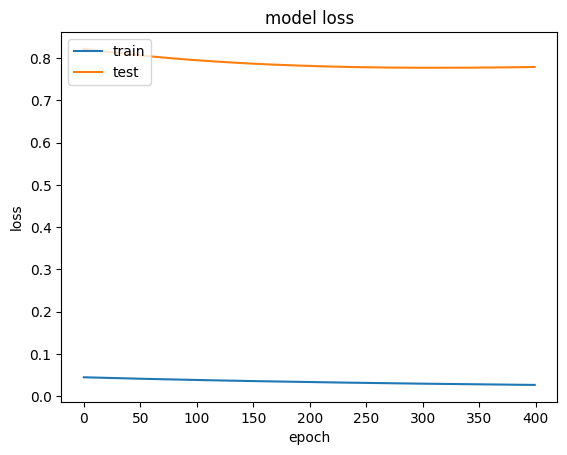

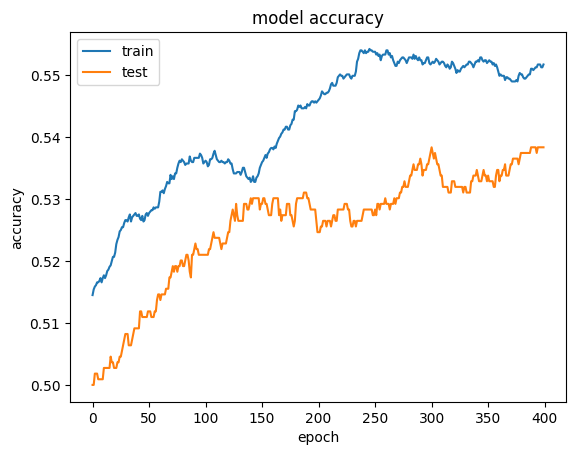

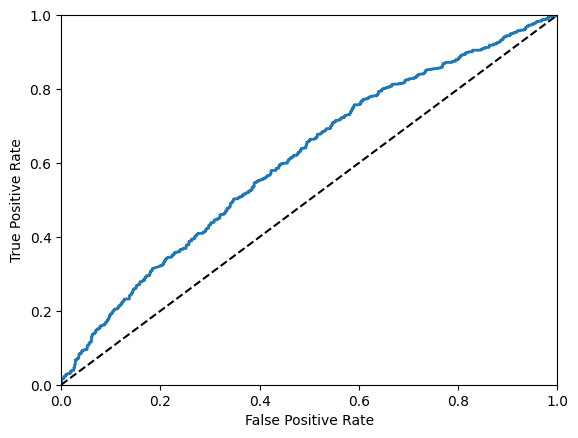

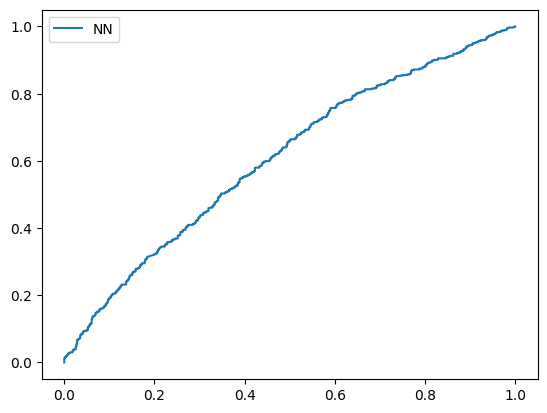

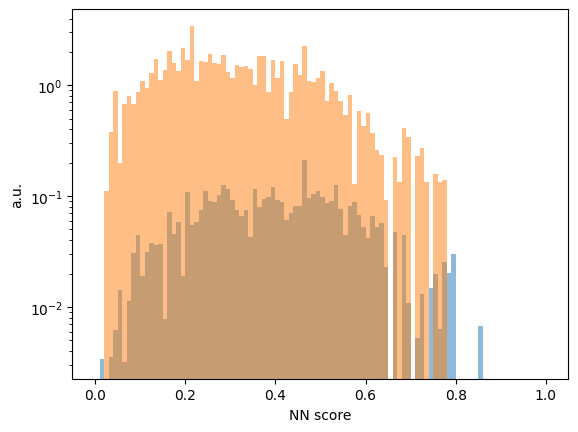

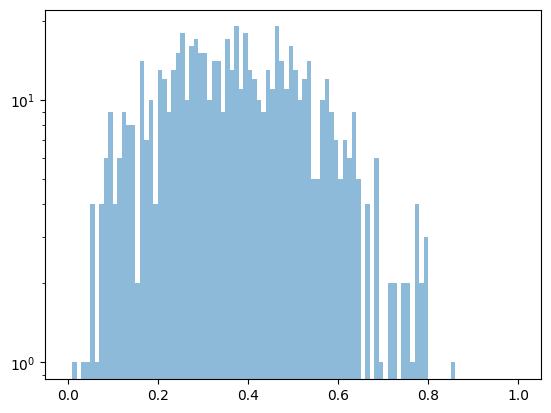

0.045694610736880664
0.746974999278224


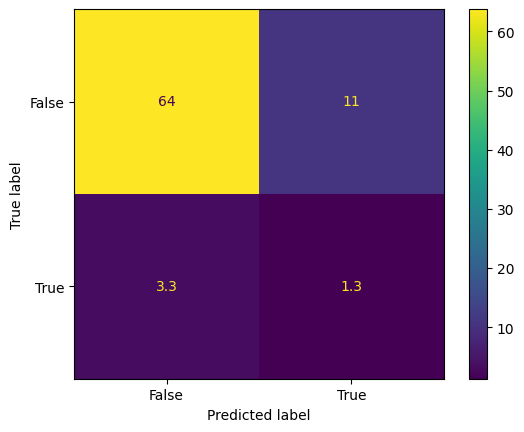

(1371,)


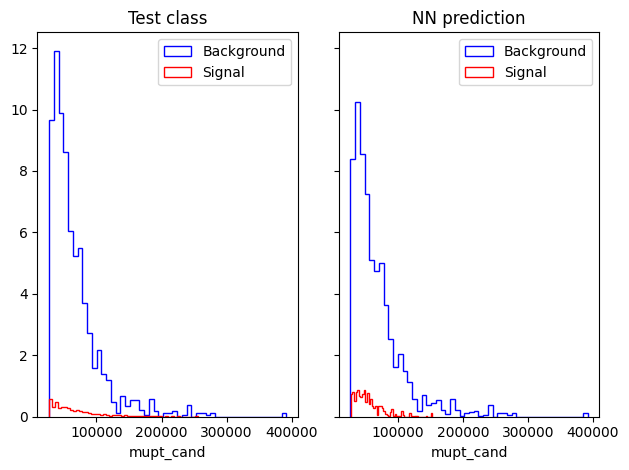

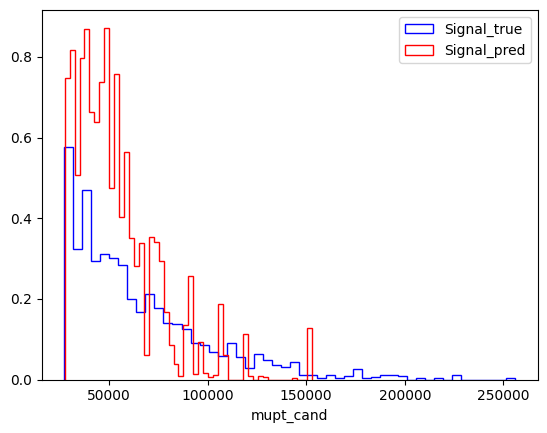

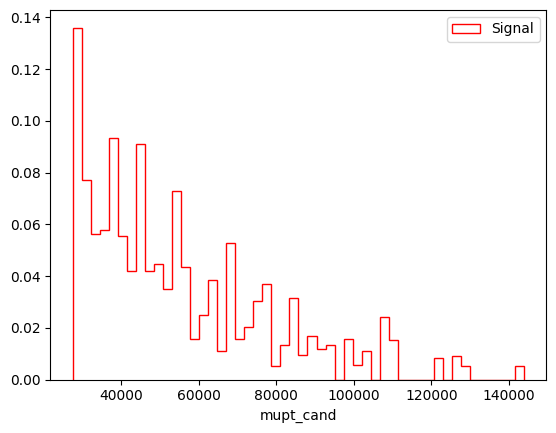

1.2938919136079576


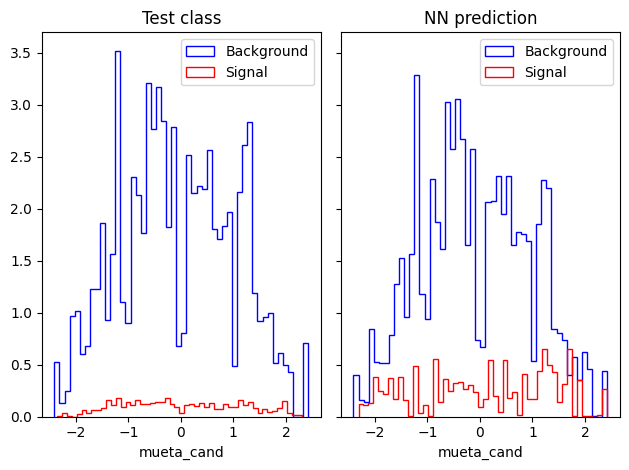

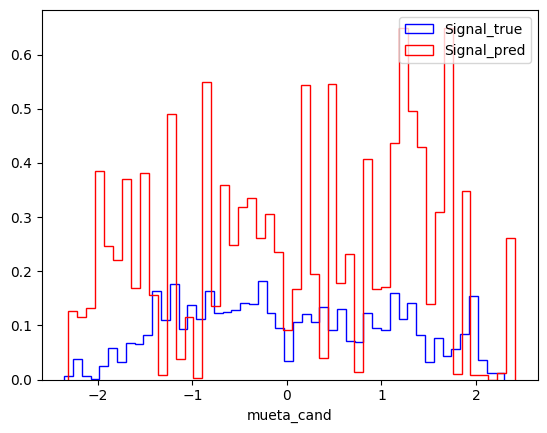

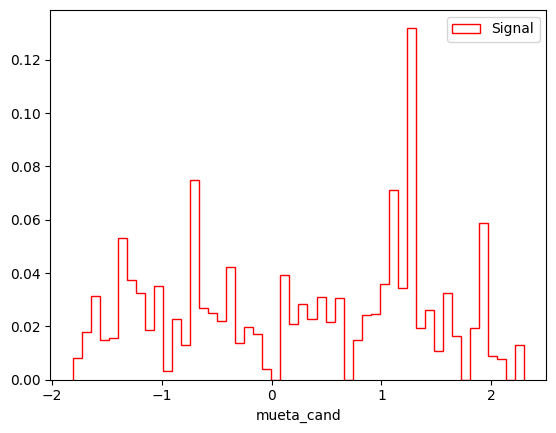

1.2938919136079576


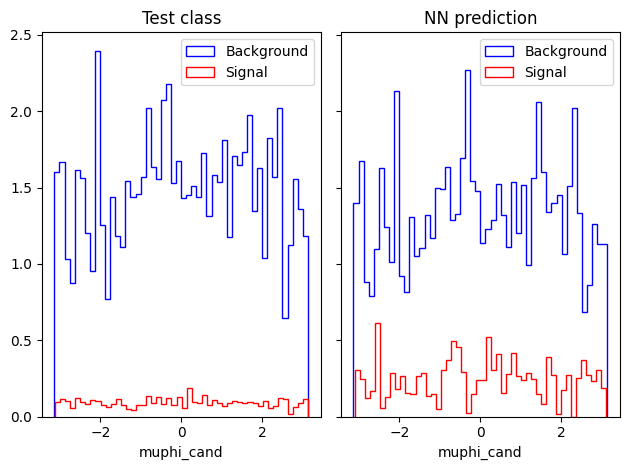

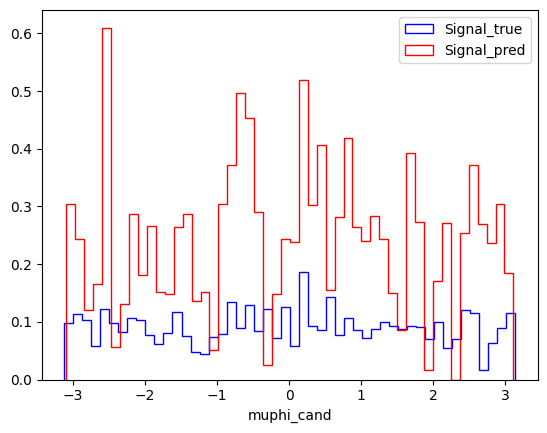

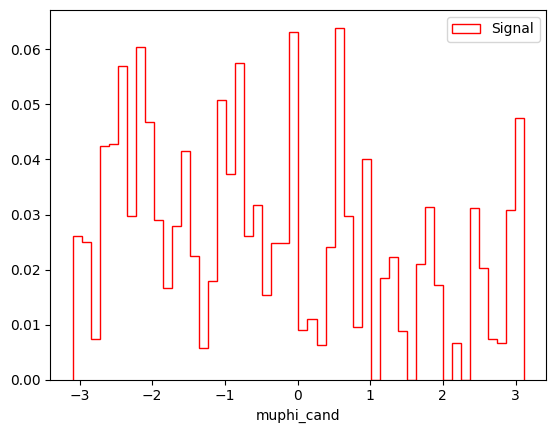

1.2938919136079572


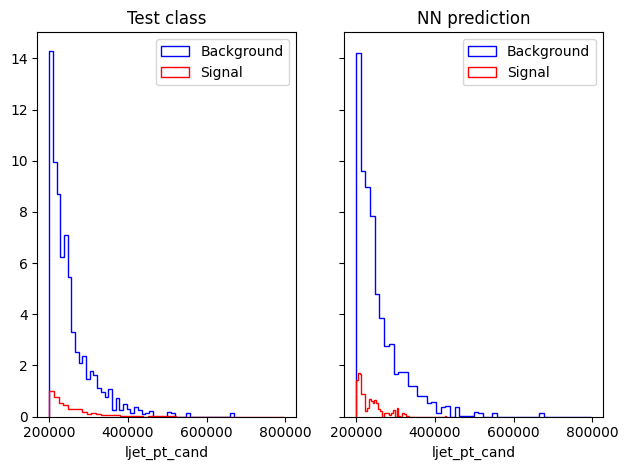

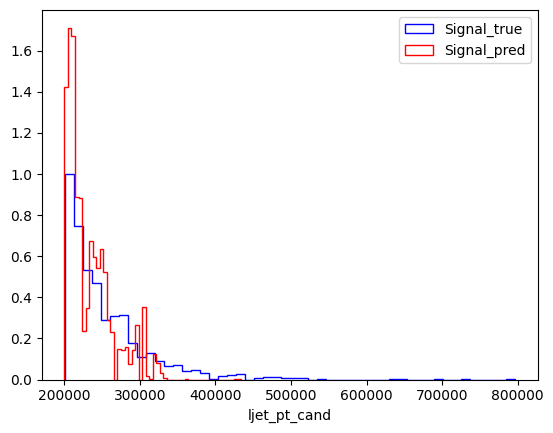

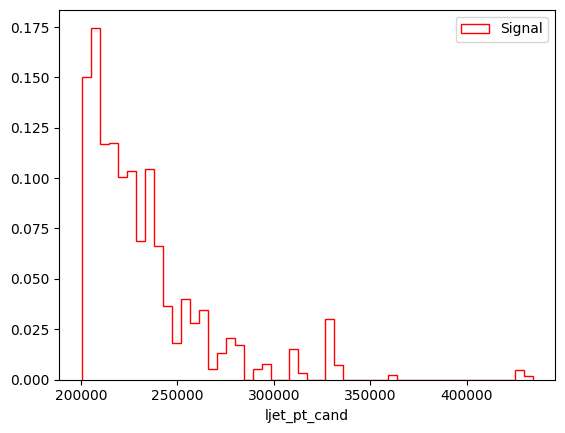

1.2938919136079576


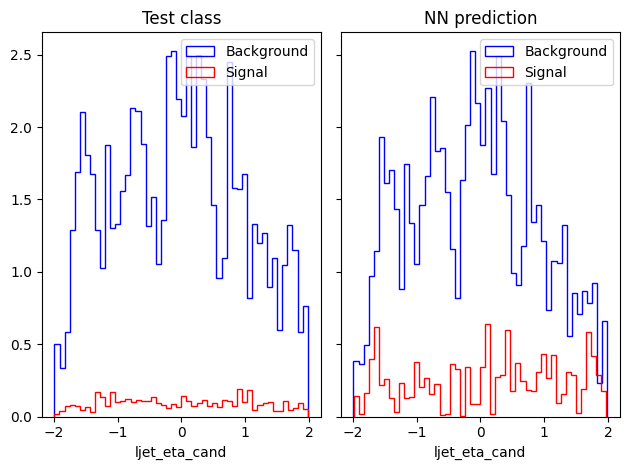

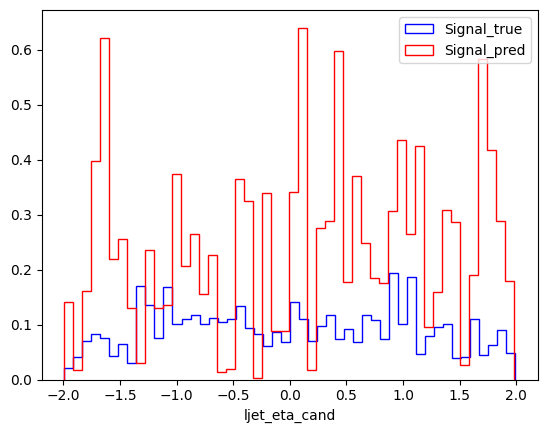

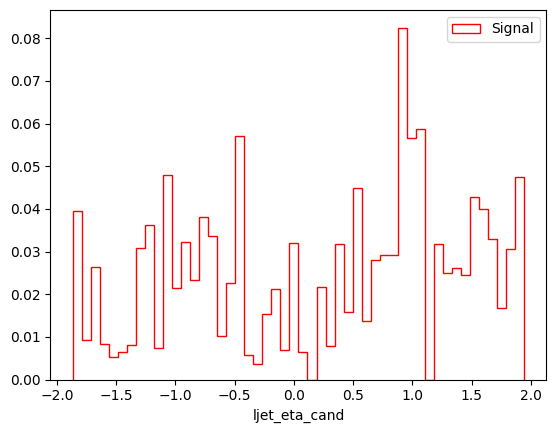

1.2938919136079574


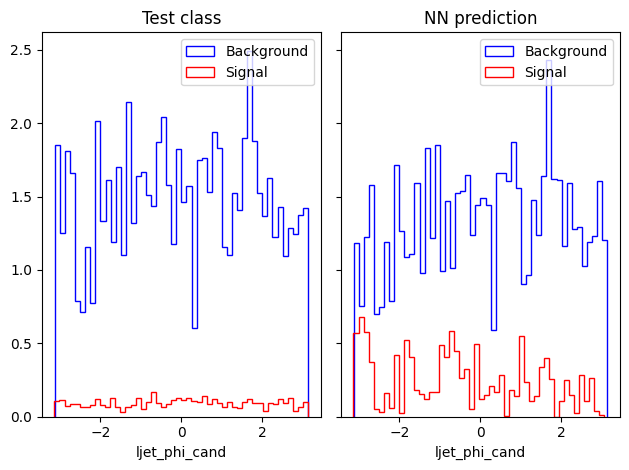

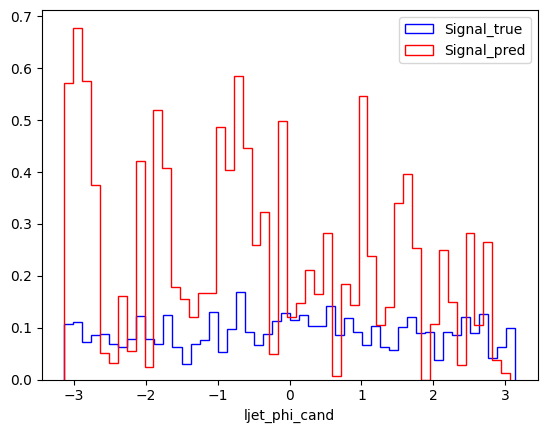

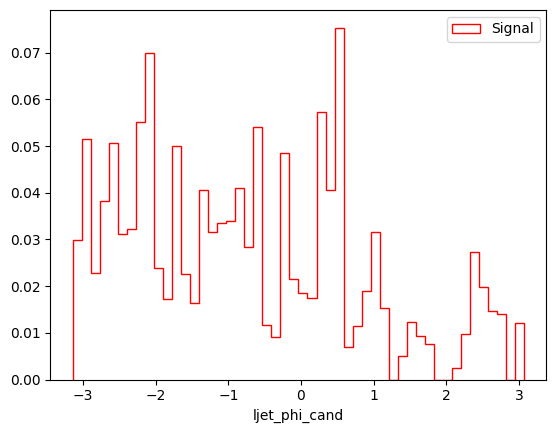

1.2938919136079574


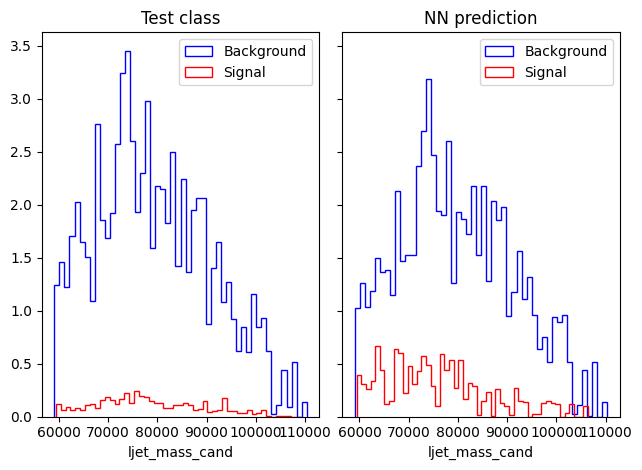

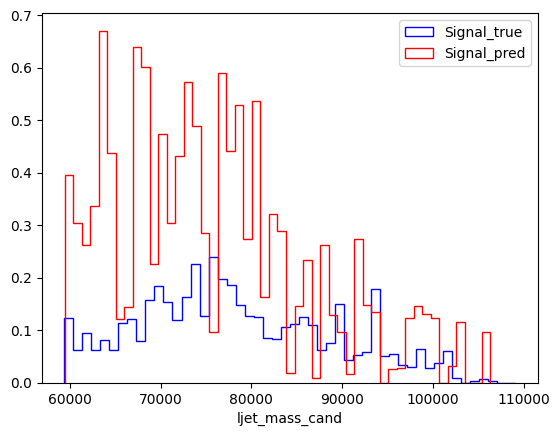

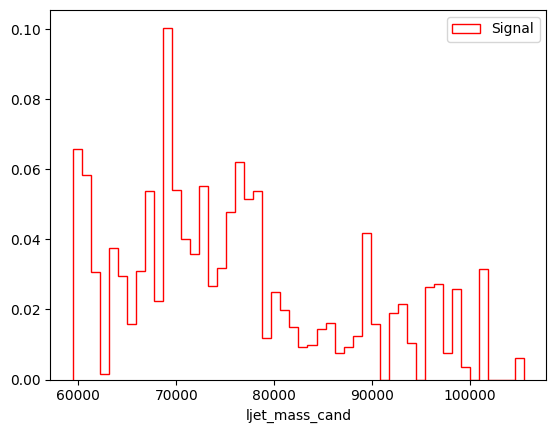

1.2938919136079579


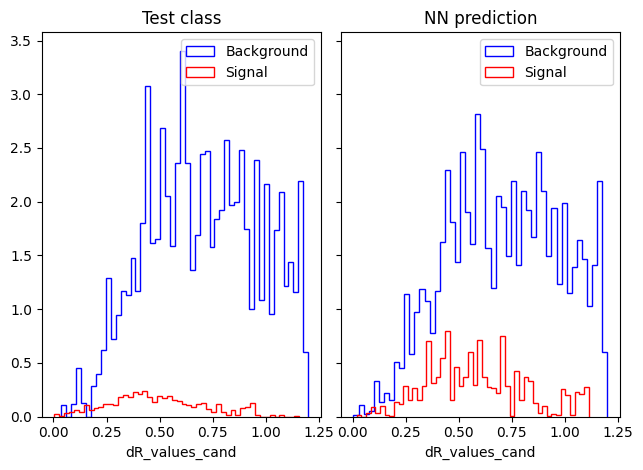

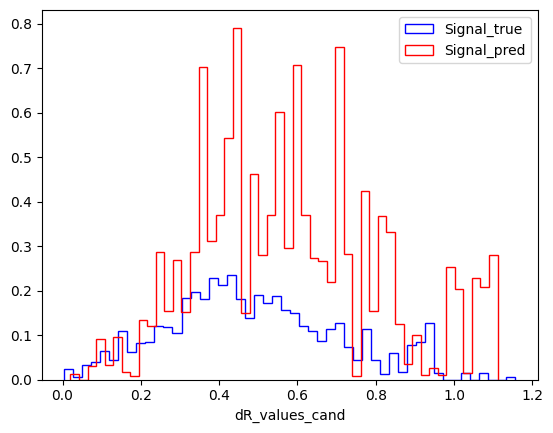

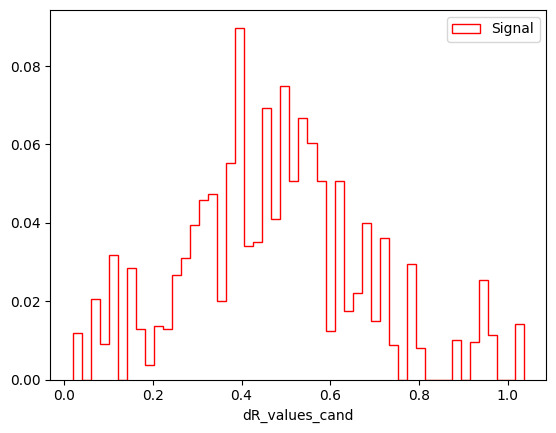

1.2938919136079579


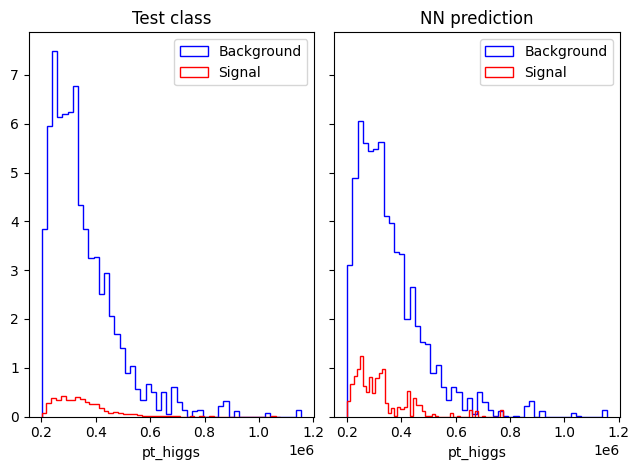

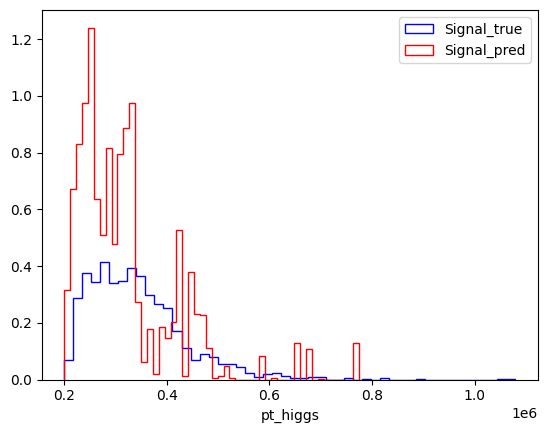

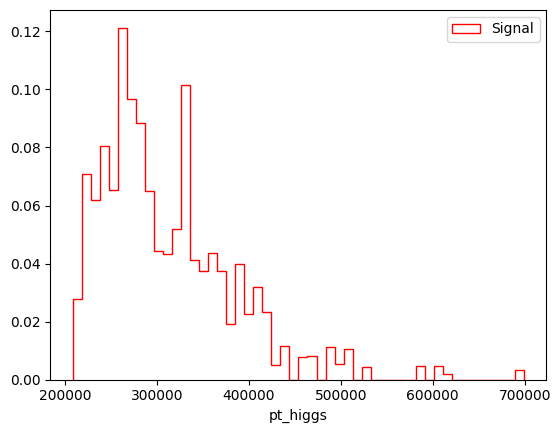

1.2938919136079576


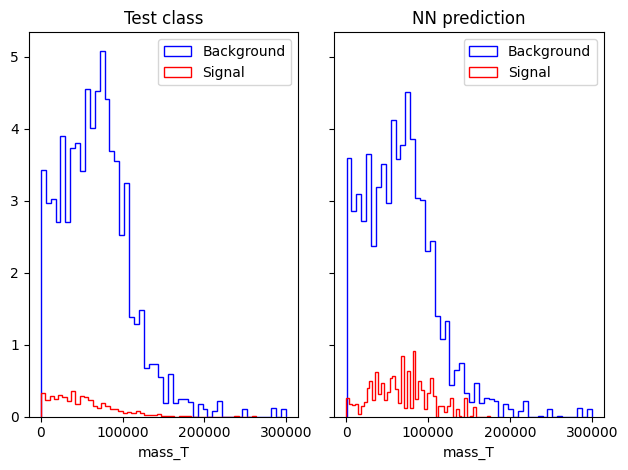

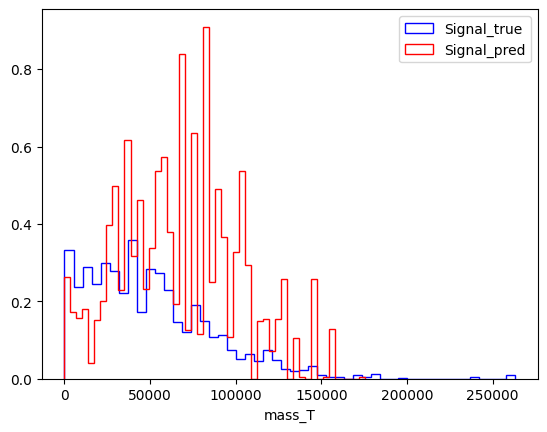

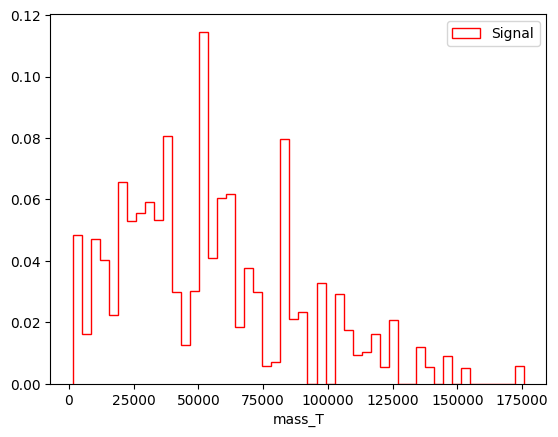

1.293891913607957


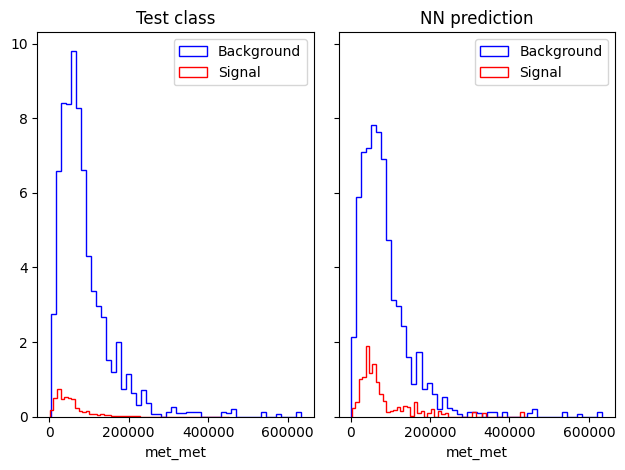

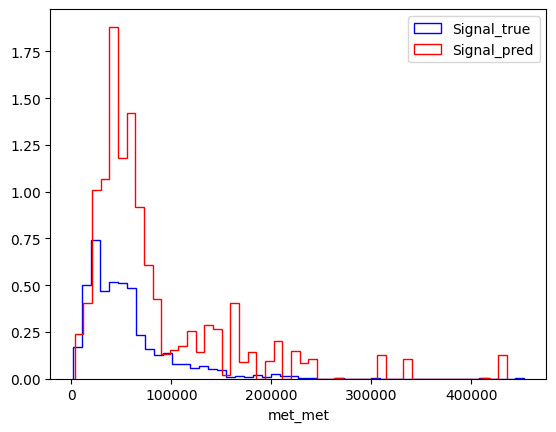

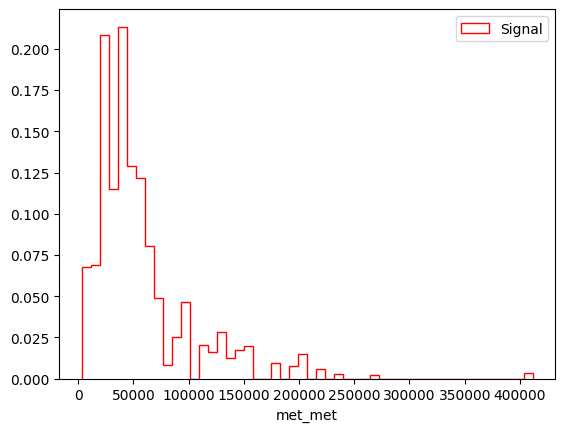

1.2938919136079574


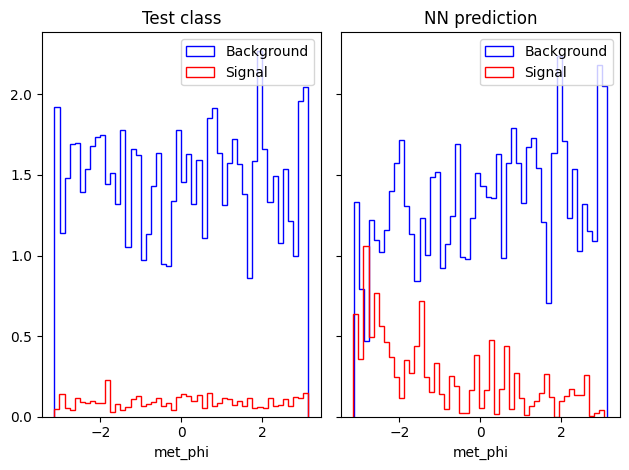

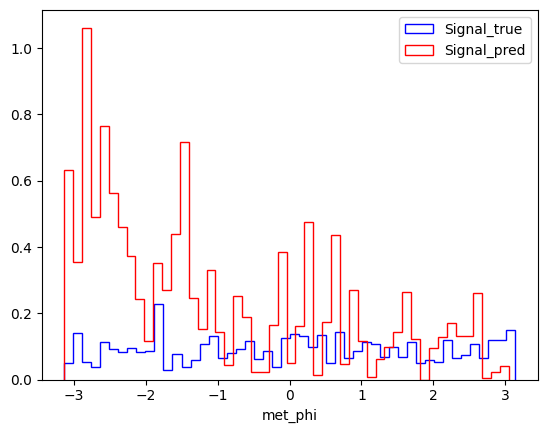

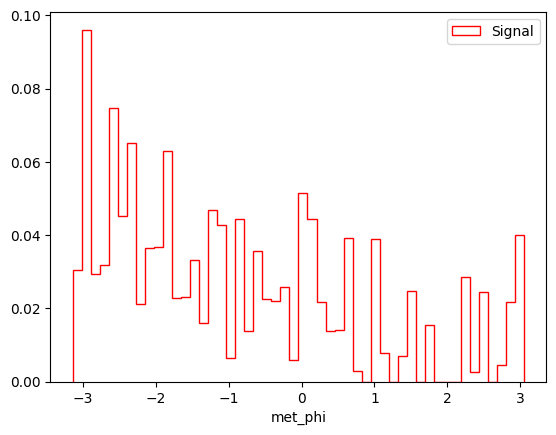

1.2938919136079576


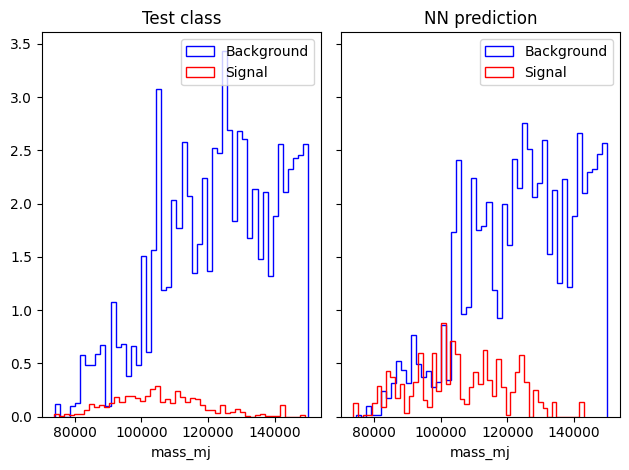

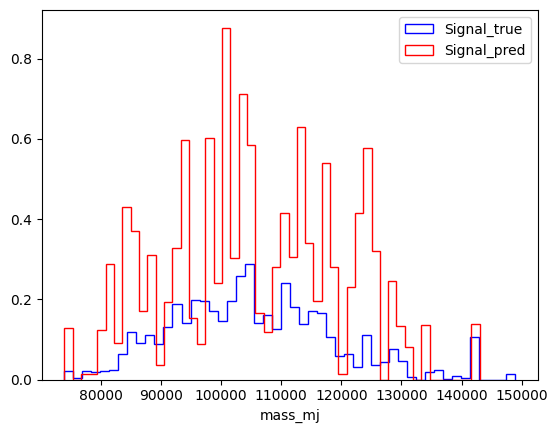

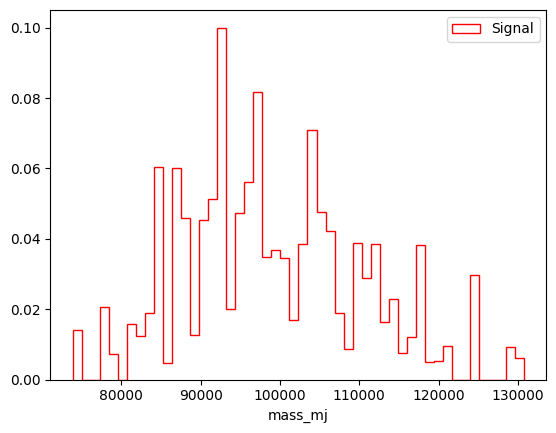

1.2938919136079576


In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(y_scores)

nn_model.summary()

nn_signal_scores = y_scores[test_class == 1]
nn_background_scores = y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, y_scores)

print("NN AUC: ", auc(nn_fakes, nn_reals))

nn_loss_plot = plot_loss(nn_fit)
nn_accuracy_plot = plot_accuracy(nn_fit)

plot_roc_curve(nn_fakes, nn_reals)

#plot signal and background scores
plt.plot(nn_fakes, nn_reals, label="NN")
plt.legend()
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='signal', weights=test_weight[test_class == 1])
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=100, range=(0,1), alpha = 0.5, label='background', weights=test_weight[test_class == 0])
plt.xlabel('NN score')
plt.ylabel('a.u.')
plt.yscale('log')
plt.show()
plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='background')
plt.yscale('log')
plt.show()

#sum of weights
print(sum(entries * np.diff(bin_edges)))
print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

#plot all test distributions with test_class and y_pred using subplots
y_pred = y_pred.flatten()
print(y_pred.shape)
for i in range(len(test_df.columns)):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)
    axs[0].hist(test_df[test_df.columns[i]][test_class == 0], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[test_class == 0])
    axs[0].hist(test_df[test_df.columns[i]][test_class == 1], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[test_class == 1])
    axs[0].set_xlabel(test_df.columns[i])
    axs[0].set_title('Test class')
    axs[0].legend()
    axs[1].hist(test_df[test_df.columns[i]][y_pred == 0], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[y_pred == 0])
    axs[1].hist(test_df[test_df.columns[i]][y_pred == 1], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[y_pred == 1])
    axs[1].set_xlabel(test_df.columns[i])
    axs[1].set_title('NN prediction')
    axs[1].legend()
    plt.show()
    print("")
    print("")
    plt.hist(test_df[test_df.columns[i]][test_class == 1], bins= 50, histtype='step', label='Signal_true', color='blue', weights=test_weight[test_class == 1])
    plt.hist(test_df[test_df.columns[i]][y_pred == 1], bins= 50, histtype='step', label='Signal_pred', color='red', weights=test_weight[y_pred == 1])
    plt.xlabel(test_df.columns[i])
    plt.legend()
    plt.show()
    print("")
    print("")
    # plt.hist(test_df[test_df.columns[i]][(test_class == 0) & (y_pred == 0)], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[(test_class == 0) & (y_pred == 0)])
    entries2, bin_edges2, c2 = plt.hist(test_df[test_df.columns[i]][(test_class == 1) & (y_pred == 1)], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[(test_class == 1) & (y_pred == 1)])
    plt.xlabel(test_df.columns[i])
    plt.legend()
    plt.show()
    print(sum(entries2))
